2025-03-14 01:04:32.601522: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 01:04:32.609110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741935872.617316  680393 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741935872.619617  680393 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741935872.626587  680393 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

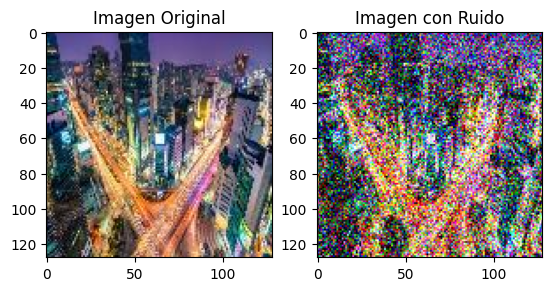

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Cargar imágenes del conjunto de entrenamiento
city_train_path = "processed_dataset/city/train-city"
forest_train_path = "processed_dataset/forest/train-forest"
img_size = (512, 512)

def load_images(folder):
    images = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Normalizar
        images.append(img)
    return np.array(images)

city_train = load_images(city_train_path)
forest_train = load_images(forest_train_path)


# Añadir Ruido Gaussiano
def add_gaussian_noise(image, mean=0, std=0.3):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image


# Añadir Ruido a las Imágene
X_train = np.concatenate([city_train, forest_train])
X_train_noisy = np.array([add_gaussian_noise(img) for img in X_train])


# Ejemplo de Imagen Ruidosa
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_train[0])
axes[0].set_title("Imagen Original")
axes[1].imshow(X_train_noisy[0])
axes[1].set_title("Imagen con Ruido")
plt.show()


In [ ]:
from tensorflow.keras.models import Model
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow.keras.layers as layers

# Inicializar un run de W&B
wandb.init(project="autoencoder-denoising", config={
    "epochs": 2500,
    "batch_size": 16,
    "img_size": img_size,
    "architecture": "autoencoder",
    "dataset": "city and forest"
})

# Configuración
config = wandb.config

input_img = layers.Input(shape=(*img_size, 3))

# Encoder
c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
c1 = layers.BatchNormalization()(c1)
p1 = layers.MaxPooling2D((2, 2), padding='same')(c1)

c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.BatchNormalization()(c2)
p2 = layers.MaxPooling2D((2, 2), padding='same')(c2)

c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.BatchNormalization()(c3)
encoded = layers.MaxPooling2D((2, 2), padding='same')(c3)

# Decoder with skip connections
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.concatenate([x, c3])

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.concatenate([x, c2])

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.concatenate([x, c1])

decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Resumen del Modelo
autoencoder.summary()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: loother (loother-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


I0000 00:00:1741935878.513963  680393 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             

 Total params: 335,747 (1.28 MB)

 Trainable params: 334,851 (1.28 MB)

 Non-trainable params: 896 (3.50 KB)

In [3]:
callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(
        filepath=f'models/model-best-{wandb.run.name}.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
history = autoencoder.fit(
    X_train_noisy,
    X_train,
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    validation_split=0.1,
    callbacks=callbacks
)

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/2500


I0000 00:00:1741935891.076046  680608 service.cc:152] XLA service 0x7f894c002b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741935891.076067  680608 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-14 01:04:51.136277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741935891.457807  680608 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3453 - loss: 0.1499

I0000 00:00:1741935897.155088  680608 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.3893 - loss: 0.1127
Epoch 1: val_loss improved from inf to 0.15304, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 859ms/step - accuracy: 0.3928 - loss: 0.1094 - val_accuracy: 0.6580 - val_loss: 0.1530
Epoch 2/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5421 - loss: 0.0420
Epoch 2: val_loss did not improve from 0.15304
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5527 - loss: 0.0413 - val_accuracy: 0.6356 - val_loss: 0.3643
Epoch 3/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6484 - loss: 0.0330
Epoch 3: val_loss did not improve from 0.15304
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6500 - loss: 0.0334 - val_accuracy: 0.0601 - val_loss: 0.4869
Epoch 4/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6657 - loss: 0.0313
Epoch 4: val_loss did not improve from 0.15304
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6682 - loss: 0.0311 - val_accuracy: 0.0542 - val_loss: 0.5406
Epoch 5/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6888 - loss: 0.0289
Epoch 5: val_loss did not improve from 0.15304
9/9 ━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7468 - loss: 0.0219 - val_accuracy: 0.4377 - val_loss: 0.0779
Epoch 44/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7545 - loss: 0.0223
Epoch 44: val_loss improved from 0.07794 to 0.03999, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7508 - loss: 0.0221 - val_accuracy: 0.4509 - val_loss: 0.0400
Epoch 45/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7714 - loss: 0.0213
Epoch 45: val_loss improved from 0.03999 to 0.03231, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7695 - loss: 0.0215 - val_accuracy: 0.6038 - val_loss: 0.0323
Epoch 46/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7298 - loss: 0.0228
Epoch 46: val_loss improved from 0.03231 to 0.02601, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7309 - loss: 0.0227 - val_accuracy: 0.6556 - val_loss: 0.0260
Epoch 47/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7573 - loss: 0.0205
Epoch 47: val_loss improved from 0.02601 to 0.02304, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7539 - loss: 0.0208 - val_accuracy: 0.7101 - val_loss: 0.0230
Epoch 48/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7729 - loss: 0.0206
Epoch 48: val_loss improved from 0.02304 to 0.02122, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7696 - loss: 0.0207 - val_accuracy: 0.7775 - val_loss: 0.0212
Epoch 49/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7697 - loss: 0.0190
Epoch 49: val_loss improved from 0.02122 to 0.02039, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7679 - loss: 0.0195 - val_accuracy: 0.7995 - val_loss: 0.0204
Epoch 50/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7525 - loss: 0.0212
Epoch 50: val_loss did not improve from 0.02039
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7535 - loss: 0.0211 - val_accuracy: 0.7866 - val_loss: 0.0207
Epoch 51/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7728 - loss: 0.0209
Epoch 51: val_loss improved from 0.02039 to 0.01995, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7678 - loss: 0.0211 - val_accuracy: 0.8104 - val_loss: 0.0199
Epoch 52/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7190 - loss: 0.0244
Epoch 52: val_loss improved from 0.01995 to 0.01960, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7246 - loss: 0.0240 - val_accuracy: 0.8096 - val_loss: 0.0196
Epoch 53/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7604 - loss: 0.0218
Epoch 53: val_loss did not improve from 0.01960
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7597 - loss: 0.0217 - val_accuracy: 0.8125 - val_loss: 0.0196
Epoch 54/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7842 - loss: 0.0206
Epoch 54: val_loss improved from 0.01960 to 0.01952, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7814 - loss: 0.0207 - val_accuracy: 0.8308 - val_loss: 0.0195
Epoch 55/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7817 - loss: 0.0203
Epoch 55: val_loss improved from 0.01952 to 0.01950, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7802 - loss: 0.0206 - val_accuracy: 0.8106 - val_loss: 0.0195
Epoch 56/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7523 - loss: 0.0221
Epoch 56: val_loss did not improve from 0.01950
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7527 - loss: 0.0219 - val_accuracy: 0.7991 - val_loss: 0.0197
Epoch 57/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7386 - loss: 0.0220
Epoch 57: val_loss improved from 0.01950 to 0.01932, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7404 - loss: 0.0219 - val_accuracy: 0.7781 - val_loss: 0.0193
Epoch 58/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7229 - loss: 0.0206
Epoch 58: val_loss did not improve from 0.01932
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7265 - loss: 0.0208 - val_accuracy: 0.7158 - val_loss: 0.0204
Epoch 59/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7688 - loss: 0.0220
Epoch 59: val_loss did not improve from 0.01932
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7691 - loss: 0.0218 - val_accuracy: 0.3265 - val_loss: 0.2433
Epoch 60/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7474 - loss: 0.0215
Epoch 60: val_loss did not improve from 0.01932
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7450 - loss: 0.0219 - val_accuracy: 0.2424 - val_loss: 0.3686
Epoch 61/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7437 - loss: 0.0245
Epoch 61: val_loss did not improve from 0.01932
9/9 ━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7545 - loss: 0.0192 - val_accuracy: 0.7350 - val_loss: 0.0185
Epoch 78/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7773 - loss: 0.0201
Epoch 78: val_loss improved from 0.01852 to 0.01836, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7735 - loss: 0.0202 - val_accuracy: 0.8136 - val_loss: 0.0184
Epoch 79/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7581 - loss: 0.0198
Epoch 79: val_loss did not improve from 0.01836
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7587 - loss: 0.0199 - val_accuracy: 0.7170 - val_loss: 0.0202
Epoch 80/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7528 - loss: 0.0195
Epoch 80: val_loss did not improve from 0.01836
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7533 - loss: 0.0196 - val_accuracy: 0.6933 - val_loss: 0.0193
Epoch 81/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7750 - loss: 0.0199
Epoch 81: val_loss did not improve from 0.01836
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7696 - loss: 0.0199 - val_accuracy: 0.6810 - val_loss: 0.0197
Epoch 82/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7628 - loss: 0.0203
Epoch 82: val_loss did not improve from 0.01836
9/9 ━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7597 - loss: 0.0199 - val_accuracy: 0.7602 - val_loss: 0.0181
Epoch 87/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7683 - loss: 0.0194
Epoch 87: val_loss improved from 0.01806 to 0.01782, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7651 - loss: 0.0193 - val_accuracy: 0.6941 - val_loss: 0.0178
Epoch 88/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7614 - loss: 0.0192
Epoch 88: val_loss did not improve from 0.01782
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7666 - loss: 0.0194 - val_accuracy: 0.7499 - val_loss: 0.0182
Epoch 89/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7637 - loss: 0.0195
Epoch 89: val_loss did not improve from 0.01782
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7641 - loss: 0.0195 - val_accuracy: 0.7088 - val_loss: 0.0179
Epoch 90/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7980 - loss: 0.0180
Epoch 90: val_loss did not improve from 0.01782
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7924 - loss: 0.0185 - val_accuracy: 0.7532 - val_loss: 0.0182
Epoch 91/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7632 - loss: 0.0187
Epoch 91: val_loss improved from 0.01782 to 0.01759, sav

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7645 - loss: 0.0189 - val_accuracy: 0.7672 - val_loss: 0.0176
Epoch 92/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7711 - loss: 0.0189
Epoch 92: val_loss did not improve from 0.01759
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7663 - loss: 0.0192 - val_accuracy: 0.7130 - val_loss: 0.0177
Epoch 93/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7569 - loss: 0.0189
Epoch 93: val_loss did not improve from 0.01759
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7592 - loss: 0.0190 - val_accuracy: 0.7761 - val_loss: 0.0176
Epoch 94/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7808 - loss: 0.0197
Epoch 94: val_loss did not improve from 0.01759
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7749 - loss: 0.0197 - val_accuracy: 0.7363 - val_loss: 0.0182
Epoch 95/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7645 - loss: 0.0200
Epoch 95: val_loss improved from 0.01759 to 0.01727, sav

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7656 - loss: 0.0197 - val_accuracy: 0.7729 - val_loss: 0.0173
Epoch 96/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7558 - loss: 0.0207
Epoch 96: val_loss did not improve from 0.01727
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7578 - loss: 0.0206 - val_accuracy: 0.7878 - val_loss: 0.0177
Epoch 97/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7516 - loss: 0.0189
Epoch 97: val_loss did not improve from 0.01727
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7543 - loss: 0.0191 - val_accuracy: 0.7703 - val_loss: 0.0178
Epoch 98/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7749 - loss: 0.0202
Epoch 98: val_loss did not improve from 0.01727
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7734 - loss: 0.0201 - val_accuracy: 0.7882 - val_loss: 0.0176
Epoch 99/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7801 - loss: 0.0197
Epoch 99: val_loss did not improve from 0.01727
9/9 ━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7556 - loss: 0.0187 - val_accuracy: 0.8133 - val_loss: 0.0173
Epoch 101/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7524 - loss: 0.0192
Epoch 101: val_loss did not improve from 0.01726
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7561 - loss: 0.0192 - val_accuracy: 0.8198 - val_loss: 0.0176
Epoch 102/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7728 - loss: 0.0187
Epoch 102: val_loss did not improve from 0.01726
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7748 - loss: 0.0188 - val_accuracy: 0.8116 - val_loss: 0.0174
Epoch 103/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7717 - loss: 0.0178
Epoch 103: val_loss improved from 0.01726 to 0.01717, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7644 - loss: 0.0181 - val_accuracy: 0.8177 - val_loss: 0.0172
Epoch 104/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7565 - loss: 0.0187
Epoch 104: val_loss did not improve from 0.01717
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7532 - loss: 0.0188 - val_accuracy: 0.8266 - val_loss: 0.0172
Epoch 105/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7542 - loss: 0.0185
Epoch 105: val_loss did not improve from 0.01717
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7560 - loss: 0.0187 - val_accuracy: 0.8281 - val_loss: 0.0173
Epoch 106/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7626 - loss: 0.0187
Epoch 106: val_loss did not improve from 0.01717
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7656 - loss: 0.0189 - val_accuracy: 0.8256 - val_loss: 0.0175
Epoch 107/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7844 - loss: 0.0190
Epoch 107: val_loss did not improve from 0.01717


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7696 - loss: 0.0183 - val_accuracy: 0.8204 - val_loss: 0.0172
Epoch 118/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7755 - loss: 0.0183
Epoch 118: val_loss did not improve from 0.01717
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7730 - loss: 0.0183 - val_accuracy: 0.8232 - val_loss: 0.0174
Epoch 119/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7771 - loss: 0.0192
Epoch 119: val_loss did not improve from 0.01717
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7792 - loss: 0.0190 - val_accuracy: 0.8071 - val_loss: 0.0173
Epoch 120/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7666 - loss: 0.0190
Epoch 120: val_loss did not improve from 0.01717
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7671 - loss: 0.0193 - val_accuracy: 0.8335 - val_loss: 0.0173
Epoch 121/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7581 - loss: 0.0195
Epoch 121: val_loss did not improve from 0.01717


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7820 - loss: 0.0190 - val_accuracy: 0.8364 - val_loss: 0.0171
Epoch 123/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7632 - loss: 0.0191
Epoch 123: val_loss did not improve from 0.01711
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7661 - loss: 0.0190 - val_accuracy: 0.8343 - val_loss: 0.0179
Epoch 124/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7785 - loss: 0.0187
Epoch 124: val_loss did not improve from 0.01711
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7745 - loss: 0.0188 - val_accuracy: 0.8393 - val_loss: 0.0174
Epoch 125/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7515 - loss: 0.0184
Epoch 125: val_loss did not improve from 0.01711
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7566 - loss: 0.0187 - val_accuracy: 0.5286 - val_loss: 0.1062
Epoch 126/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7427 - loss: 0.0203
Epoch 126: val_loss did not improve from 0.01711


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7752 - loss: 0.0182 - val_accuracy: 0.8209 - val_loss: 0.0170
Epoch 150/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7699 - loss: 0.0188
Epoch 150: val_loss improved from 0.01701 to 0.01690, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7718 - loss: 0.0186 - val_accuracy: 0.8258 - val_loss: 0.0169
Epoch 151/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7614 - loss: 0.0186
Epoch 151: val_loss improved from 0.01690 to 0.01690, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7600 - loss: 0.0184 - val_accuracy: 0.8124 - val_loss: 0.0169
Epoch 152/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7569 - loss: 0.0186
Epoch 152: val_loss did not improve from 0.01690
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7632 - loss: 0.0185 - val_accuracy: 0.8317 - val_loss: 0.0172
Epoch 153/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7873 - loss: 0.0179
Epoch 153: val_loss improved from 0.01690 to 0.01682, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7886 - loss: 0.0179 - val_accuracy: 0.8369 - val_loss: 0.0168
Epoch 154/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7793 - loss: 0.0189
Epoch 154: val_loss did not improve from 0.01682
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7786 - loss: 0.0188 - val_accuracy: 0.8279 - val_loss: 0.0170
Epoch 155/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7929 - loss: 0.0184
Epoch 155: val_loss improved from 0.01682 to 0.01680, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7926 - loss: 0.0183 - val_accuracy: 0.8460 - val_loss: 0.0168
Epoch 156/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7746 - loss: 0.0183
Epoch 156: val_loss did not improve from 0.01680
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7782 - loss: 0.0183 - val_accuracy: 0.8337 - val_loss: 0.0175
Epoch 157/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7861 - loss: 0.0186
Epoch 157: val_loss did not improve from 0.01680
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7789 - loss: 0.0183 - val_accuracy: 0.8224 - val_loss: 0.0170
Epoch 158/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8016 - loss: 0.0191
Epoch 158: val_loss did not improve from 0.01680
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7962 - loss: 0.0188 - val_accuracy: 0.8310 - val_loss: 0.0172
Epoch 159/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7367 - loss: 0.0183
Epoch 159: val_loss did not improve from 0.01680


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7719 - loss: 0.0174 - val_accuracy: 0.8422 - val_loss: 0.0168
Epoch 200/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7731 - loss: 0.0175
Epoch 200: val_loss did not improve from 0.01677
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7691 - loss: 0.0175 - val_accuracy: 0.7965 - val_loss: 0.0176
Epoch 201/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7909 - loss: 0.0172
Epoch 201: val_loss did not improve from 0.01677
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7866 - loss: 0.0174 - val_accuracy: 0.8196 - val_loss: 0.0178
Epoch 202/2500
4/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7625 - loss: 0.0178
Epoch 202: val_loss did not improve from 0.01677
9/9 ━━━━━━━━━━━━━━━━━━━━ -1s -135920us/step - accuracy: 0.7632 - loss: 0.0176 - val_accuracy: 0.8255 - val_loss: 0.0179
Epoch 203/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8037 - loss: 0.0190
Epoch 203: val_loss did not improve from 0.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7997 - loss: 0.0173 - val_accuracy: 0.8361 - val_loss: 0.0166
Epoch 213/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7872 - loss: 0.0195
Epoch 213: val_loss did not improve from 0.01664
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7829 - loss: 0.0192 - val_accuracy: 0.8378 - val_loss: 0.0171
Epoch 214/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7764 - loss: 0.0178
Epoch 214: val_loss did not improve from 0.01664
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7746 - loss: 0.0177 - val_accuracy: 0.8318 - val_loss: 0.0168
Epoch 215/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7649 - loss: 0.0183
Epoch 215: val_loss did not improve from 0.01664
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7660 - loss: 0.0182 - val_accuracy: 0.8163 - val_loss: 0.0171
Epoch 216/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7849 - loss: 0.0172
Epoch 216: val_loss did not improve from 0.01664


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7932 - loss: 0.0175 - val_accuracy: 0.8454 - val_loss: 0.0165
Epoch 222/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7832 - loss: 0.0172
Epoch 222: val_loss did not improve from 0.01646
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7839 - loss: 0.0171 - val_accuracy: 0.8390 - val_loss: 0.0169
Epoch 223/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7822 - loss: 0.0168
Epoch 223: val_loss did not improve from 0.01646
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7833 - loss: 0.0168 - val_accuracy: 0.8321 - val_loss: 0.0168
Epoch 224/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7977 - loss: 0.0167
Epoch 224: val_loss did not improve from 0.01646
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7951 - loss: 0.0169 - val_accuracy: 0.8338 - val_loss: 0.0170
Epoch 225/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7981 - loss: 0.0160
Epoch 225: val_loss did not improve from 0.01646


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7999 - loss: 0.0165 - val_accuracy: 0.8343 - val_loss: 0.0164
Epoch 237/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7885 - loss: 0.0170
Epoch 237: val_loss did not improve from 0.01642
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7903 - loss: 0.0169 - val_accuracy: 0.8205 - val_loss: 0.0165
Epoch 238/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7980 - loss: 0.0176
Epoch 238: val_loss did not improve from 0.01642
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7966 - loss: 0.0175 - val_accuracy: 0.8311 - val_loss: 0.0168
Epoch 239/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7723 - loss: 0.0172
Epoch 239: val_loss did not improve from 0.01642
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7743 - loss: 0.0172 - val_accuracy: 0.8330 - val_loss: 0.0169
Epoch 240/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7851 - loss: 0.0173
Epoch 240: val_loss did not improve from 0.01642


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7899 - loss: 0.0170 - val_accuracy: 0.8310 - val_loss: 0.0164
Epoch 267/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7876 - loss: 0.0171
Epoch 267: val_loss did not improve from 0.01641
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7859 - loss: 0.0171 - val_accuracy: 0.8258 - val_loss: 0.0169
Epoch 268/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8064 - loss: 0.0162
Epoch 268: val_loss did not improve from 0.01641
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8007 - loss: 0.0166 - val_accuracy: 0.8215 - val_loss: 0.0166
Epoch 269/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7721 - loss: 0.0166
Epoch 269: val_loss did not improve from 0.01641
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7742 - loss: 0.0167 - val_accuracy: 0.8409 - val_loss: 0.0168
Epoch 270/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7766 - loss: 0.0160
Epoch 270: val_loss did not improve from 0.01641

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8002 - loss: 0.0159 - val_accuracy: 0.8118 - val_loss: 0.0164
Epoch 393/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7877 - loss: 0.0161
Epoch 393: val_loss improved from 0.01637 to 0.01631, saving model to models/model-best-blueberry-square-9.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7862 - loss: 0.0160 - val_accuracy: 0.8111 - val_loss: 0.0163
Epoch 394/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7974 - loss: 0.0166
Epoch 394: val_loss did not improve from 0.01631
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7946 - loss: 0.0166 - val_accuracy: 0.8126 - val_loss: 0.0172
Epoch 395/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7817 - loss: 0.0167
Epoch 395: val_loss did not improve from 0.01631
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7828 - loss: 0.0166 - val_accuracy: 0.7422 - val_loss: 0.0373
Epoch 396/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7846 - loss: 0.0163
Epoch 396: val_loss did not improve from 0.01631
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7867 - loss: 0.0163 - val_accuracy: 0.7075 - val_loss: 0.0289
Epoch 397/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7803 - loss: 0.0164
Epoch 397: val_loss did not improve from 0.01631


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7627 - loss: 0.0166 - val_accuracy: 0.8212 - val_loss: 0.0162
Epoch 405/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7858 - loss: 0.0167
Epoch 405: val_loss did not improve from 0.01616
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7898 - loss: 0.0165 - val_accuracy: 0.8261 - val_loss: 0.0168
Epoch 406/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8132 - loss: 0.0159
Epoch 406: val_loss did not improve from 0.01616
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8088 - loss: 0.0159 - val_accuracy: 0.8104 - val_loss: 0.0165
Epoch 407/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7775 - loss: 0.0155
Epoch 407: val_loss did not improve from 0.01616
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7787 - loss: 0.0157 - val_accuracy: 0.8079 - val_loss: 0.0168
Epoch 408/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7782 - loss: 0.0153
Epoch 408: val_loss did not improve from 0.01616


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8124 - loss: 0.0128 - val_accuracy: 0.8249 - val_loss: 0.0161
Epoch 2322/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8036 - loss: 0.0127
Epoch 2322: val_loss did not improve from 0.01613
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8066 - loss: 0.0127 - val_accuracy: 0.8212 - val_loss: 0.0167
Epoch 2323/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8207 - loss: 0.0129
Epoch 2323: val_loss did not improve from 0.01613
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8195 - loss: 0.0128 - val_accuracy: 0.8204 - val_loss: 0.0163
Epoch 2324/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8288 - loss: 0.0124
Epoch 2324: val_loss did not improve from 0.01613
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8243 - loss: 0.0124 - val_accuracy: 0.8204 - val_loss: 0.0162
Epoch 2325/2500
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8256 - loss: 0.0128
Epoch 2325: val_loss did not improve from 

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step


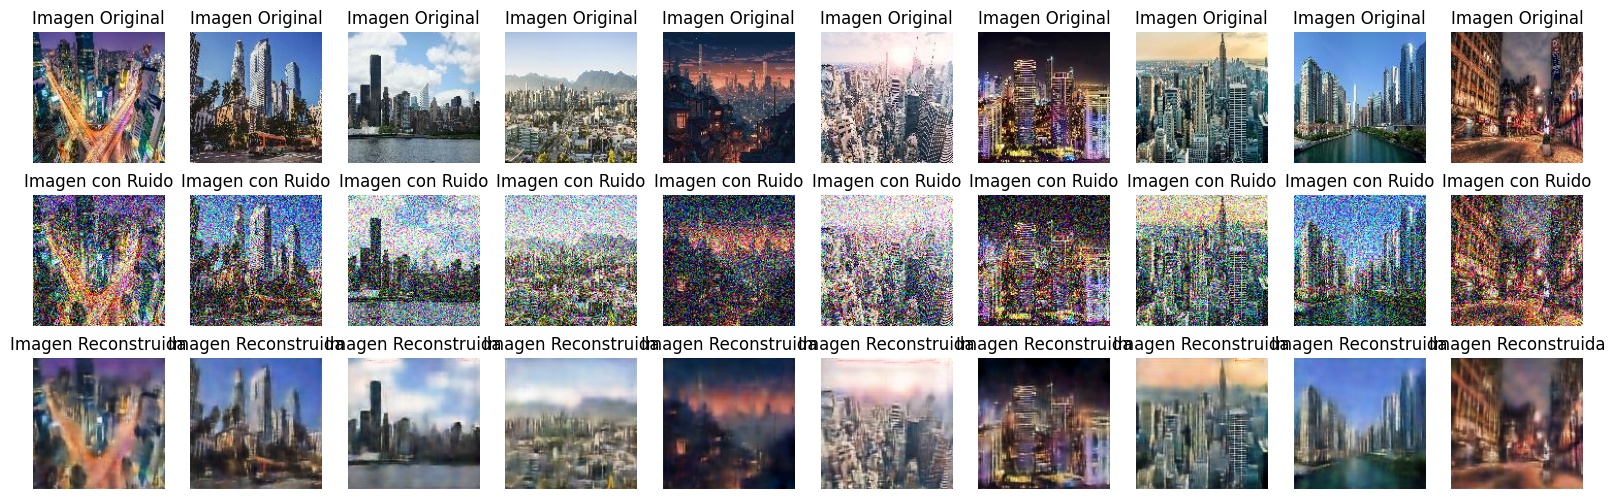

Train MSE: 0.013456256075258986
Train PSNR: 18.710757567562013 dB


/tmp/ipykernel_680393/2811937633.py:39: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(X_train, decoded_imgs)


In [4]:
from tensorflow.keras.metrics import MeanSquaredError
from skimage.metrics import peak_signal_noise_ratio as psnr

# Cargar el mejor modelo
autoencoder = tf.keras.models.load_model(f'models/model-best-{wandb.run.name}.h5', custom_objects={'mse': MeanSquaredError()})

# Comparar Imágenes
decoded_imgs = autoencoder.predict(X_train_noisy)

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_train[i])
    plt.title("Imagen Original")
    plt.axis('off')

    # Imagen Original con Ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_train_noisy[i])
    plt.title("Imagen con Ruido")
    plt.axis('off')

    # Imagen Reconstruida
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Imagen Reconstruida")
    plt.axis('off')

plt.show()

# Mean Squared Error
mse = np.mean((X_train - decoded_imgs) ** 2)
print(f"Train MSE: {mse}")

# Peak Signal-to-Noise Ratio
psnr_value = psnr(X_train, decoded_imgs)
print(f"Train PSNR: {psnr_value} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


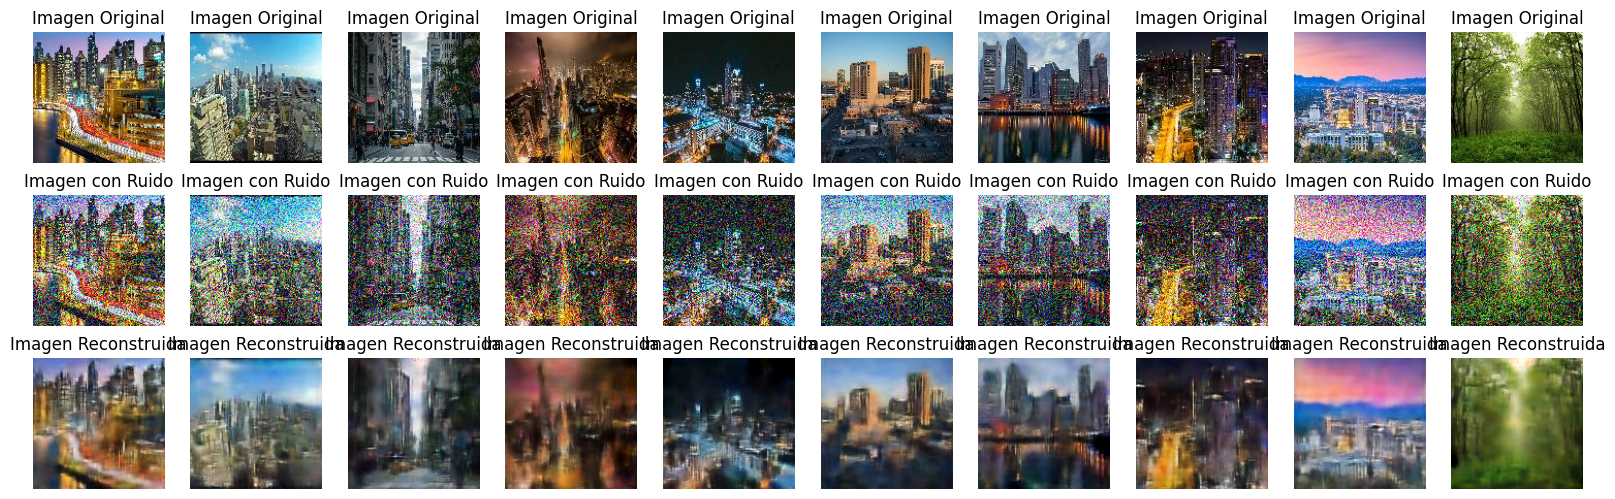

Train MSE: 0.01693077641828449
Train PSNR: 17.713231253851646 dB


/tmp/ipykernel_680393/3502570458.py:46: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(X_test, decoded_imgs)


In [5]:
# Prueba con Imágenes Nuevas
city_test_path = "processed_dataset/city/test-city"
forest_test_path = "processed_dataset/forest/test-forest"

city_test = load_images(city_test_path)
forest_test = load_images(forest_test_path)

X_test = np.concatenate([city_test, forest_test])
X_test_noisy = np.array([add_gaussian_noise(img) for img in X_test])

decoded_imgs = autoencoder.predict(X_test_noisy)
from skimage.metrics import peak_signal_noise_ratio as psnr

# Comparar Imágenes
decoded_imgs = autoencoder.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 6))  # Adjust the figure size to accommodate three rows

for i in range(n):
    # Imagen Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Imagen Original")
    plt.axis('off')

    # Imagen Original con Ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[i])
    plt.title("Imagen con Ruido")
    plt.axis('off')

    # Imagen Reconstruida
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Imagen Reconstruida")
    plt.axis('off')

plt.show()

# Mean Squared Error
mse = np.mean((X_test - decoded_imgs) ** 2)
print(f"Train MSE: {mse}")

# Peak Signal-to-Noise Ratio
psnr_value = psnr(X_test, decoded_imgs)
print(f"Train PSNR: {psnr_value} dB")